# Training

In [12]:
#library for regular expressions
import re

#library to read and import file from drive
import os

import cv2 as cv

import matplotlib.pyplot as plt

import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model
from tensorflow import keras
from utility import data_loader, predict_image


## Data loader

In [8]:
X_train = data_loader('../Data/Prepared/Train/OK', scale=True)
X_noisy = data_loader('../Data/Prepared/Train/noisyOK', scale=True)
X_anomaly = data_loader('../Data/Prepared/Train/NOK', scale=False)

## Train e validation set

In [17]:
X_train, X__train_val = train_test_split(np.expand_dims(np.array(X_train), -1), test_size=0.2, random_state=17)
X_noisy, X__noisy_val = train_test_split(np.expand_dims(np.array(X_noisy), -1), test_size=0.2, random_state=17)

# Autoencoder

In [18]:
img_shape = X_train.shape[1:]
input_img = Input(img_shape)

#encoded = Dense(1, activation='relu')
encoded = Flatten()(input_img)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(np.prod(img_shape))(decoded)
decoded = Reshape((img_shape))(decoded)

In [19]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adamax', loss='mse')

In [20]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               8388736   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 65536)             8454144   
_________________________________________________________________
reshape (Reshape)            (None, 256, 256, 1)      

In [29]:
#add early stopping
custom_early_stopping = EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001, mode='min')

#random seed 
tf.random.set_seed(17)

hist=autoencoder.fit(X_noisy, X_train, epochs=300, batch_size=16, shuffle=True,
                     validation_data=(X__noisy_val, X__train_val), callbacks=[custom_early_stopping])

Epoch 1/300
149/149 [==============================] - 18s 120ms/step - loss: 0.0576 - val_loss: 0.0286
Epoch 2/300
149/149 [==============================] - 17s 117ms/step - loss: 0.0221 - val_loss: 0.0173
Epoch 3/300
149/149 [==============================] - 17s 117ms/step - loss: 0.0151 - val_loss: 0.0136
Epoch 4/300
149/149 [==============================] - 17s 117ms/step - loss: 0.0128 - val_loss: 0.0119
Epoch 5/300
149/149 [==============================] - 17s 117ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 6/300
149/149 [==============================] - 17s 117ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 7/300
149/149 [==============================] - 17s 117ms/step - loss: 0.0107 - val_loss: 0.0105
Epoch 8/300
149/149 [==============================] - 18s 118ms/step - loss: 0.0102 - val_loss: 0.0100
Epoch 9/300
149/149 [==============================] - 18s 118ms/step - loss: 0.0098 - val_loss: 0.0106
Epoch 10/300
149/149 [==============================] - 18s 123m

In [ ]:
# Function to summarize history for loss
def plot_hist(hist, title):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("LOSS " + title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

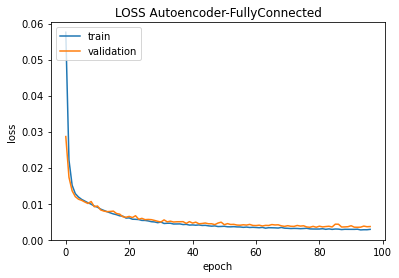

In [34]:
plot_hist(hist, 'Autoencoder-FullyConnected')

### Sample with spot artificially producted

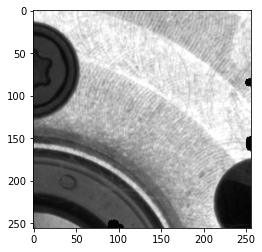

In [31]:
plt.imshow(np.squeeze(X_noisy[10],-1), cmap='gray')

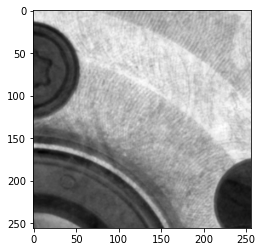

In [32]:
test_artificial = autoencoder.predict(np.expand_dims(X_noisy[10],0))
plt.imshow(np.squeeze(test_artificial[0], -1), cmap='gray')

### Saving model 

In [33]:
autoencoder.save("../Models/autoencoderFC")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../Models/autoencoderFC\assets


# Prediction of anomalies
Anomalies are detected and located by analysis the differences between the orignal image and the one reconstructed by the autoencoder. The original image is first preprocessed, divided in slices and every slice is processed by the autoencoder. The processed slices are then concateneted to reconstruct the full image.
The result of the difference between the 2 images is processed by the opencv function threshold, so the pixel that are different in the 2 images will become white and all the rest will be black. From that mask is possible to extract the bounding boxes of the white pixels, to show where the anomalies are. 

Images are predicted as defective if there is at least one anomaly detected. The reconstruction score (SSIM between the original image and the reconstructed one) is given to understand if the autoencoder was able to effectively reconstruct the image.

In [6]:
autoencoder = keras.models.load_model("../Models/autoencoderFC")

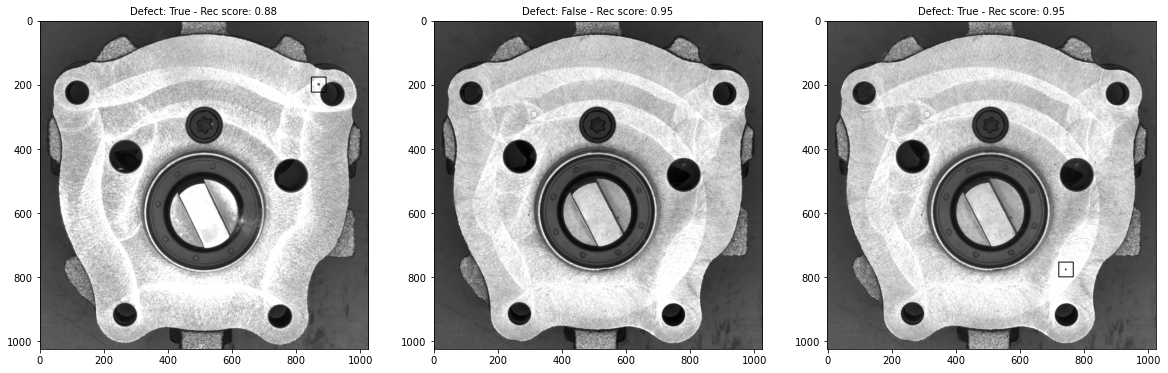

In [10]:
plt.figure(figsize=(20, 20))
i=1
for img in X_anomaly:
    anom, img_anom, sim_score = predict_image(img, autoencoder)
    plt.subplot(1, 3, i)
    plt.title('Defect: ' + str(anom) + ' - Rec score: ' + str(round(sim_score, 2)), fontsize=10)
    plt.imshow(img_anom, cmap='gray')
    i=i+1